# Importing Data and Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV

In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


we see that we don't have any null values

In [ ]:
#we don't need the id column so we can drop it
df.drop('id',axis=1,inplace=True)

In [ ]:
df.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


# EDA

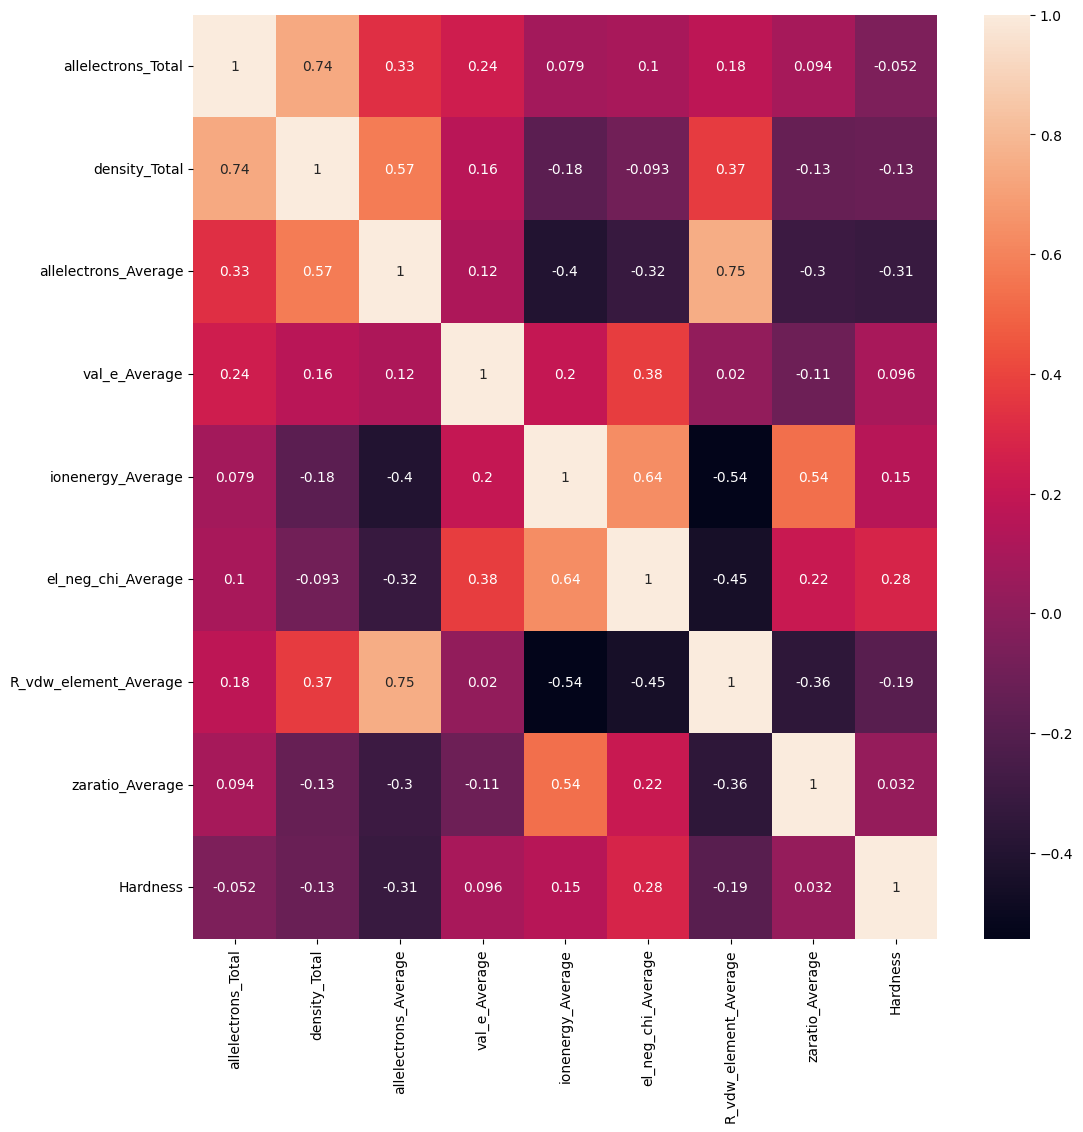

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(),annot=True)
plt.show()

attributes that are high correlated with each other are (atomicweight_Average,allelectrons_Average),(density_Average with both atomicweight_Average and allelectrons_Average)

In [ ]:
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [ ]:
#plotting each attribute against Hardness
plt.figure(figsize=(8,12))
i=1;
for c in df.columns.tolist():
    if c != 'Hardness':
        plt.subplot(4, 3, i)
        df.plot(kind='scatter', x=c, y='Hardness', ax=plt.gca(),alpha=0.2)
        plt.title(f'Scatter plot of {c} vs Hardness')
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
#plotting each attribute
plt.figure(figsize=(8,12))
i=1;
for c in df.columns.tolist():
    if c != 'Hardness':
        plt.subplot(4, 3, i)
        temp = pd.DataFrame(df[c])
        plt.scatter(temp.index, temp[c],alpha=0.2)
        plt.title(f'Scatter plot of {c}')
        i += 1

plt.tight_layout()
plt.show()

we didn't gain much insights from these plots, let's see the distribution

In [ ]:
plt.figure(figsize=(12,12))
i=1
for c in df.columns.tolist():
   if c != 'Hardness':
        plt.subplot(4, 3, i)
        sns.histplot(x=df[c],bins=30)
        i += 1



*  we can see that there is a lot of outliers in our data

*  some of the attributes require transformation




In [ ]:
#plotting outliers
plt.figure(figsize=(12,12))
i=1
for c in df.columns.tolist():
   if c != 'Hardness':
        plt.subplot(4, 3, i)
        sns.boxplot(x=df[c])
        i += 1



     In the next preprocessing phase :
1.   First we will drop one of the high correlated non target features
2.   second we will remove outliers using upper and lower bound , then re plot the distribution
3.   we will apply the corresponding transformation on the data to fix the skewed distributions
4.   we will transform the data to the target range



# Data Preprocessing

In [ ]:
def handle_outliers(data_frame, column, lower_quantile=0.025, upper_quantile=0.975, action='remove'):
    lower_bound = data_frame[column].quantile(lower_quantile)
    upper_bound = data_frame[column].quantile(upper_quantile)

    outliers = data_frame[(data_frame[column] < lower_bound) | (data_frame[column] > upper_bound)]

    if action == 'remove':
        data_frame = data_frame.drop(outliers.index)
    return data_frame


In [ ]:
for c in df.columns:
  df=handle_outliers(df,c,action='remove')

In [ ]:
df.shape

(5958, 12)

In [ ]:
X=df.drop('Hardness',axis=1)
y=df['Hardness']

In [ ]:
def high_corr(data, thres):
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= thres)]
    return to_drop

In [ ]:
def norm(data):
   pt = PowerTransformer(method='yeo-johnson', standardize=False)
   columns_to_transform = [c for c in data.columns if c != 'Hardness']
   data[columns_to_transform] = pt.fit_transform(data[columns_to_transform])
   return data

In [ ]:
def mms(X):
   scaler=MinMaxScaler(feature_range=(1, 10))
   X=scaler.fit_transform(X)
   X=np.array(X)
   X=pd.DataFrame(X)
   return X

In [ ]:
dropped=high_corr(X,0.8)

<ipython-input-117-94f1f15805df>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [ ]:
df.drop(dropped,axis=1,inplace=True)

In [ ]:
df=norm(df)

In [ ]:
X=df.drop('Hardness',axis=1)
X=mms(X)

# Models Implementation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    HuberRegressor(),
    BayesianRidge(),
    SVR(),
    CatBoostRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor(),
    XGBRegressor(),
    KNeighborsRegressor()
]
acc=[]
for model in models:
    model.fit(x_train, y_train)
    y_hat_train=model.predict(x_train)
    y_pred = model.predict(x_test)
    acc_train=median_absolute_error(y_hat_train, y_train)
    accuracy = median_absolute_error(y_pred, y_test)
    acc.append(accuracy)
    print(model)
    print(f'Median Absolute Error train: {acc_train}')
    print(f'Median Absolute Error test: {accuracy}')
    print('---------------------------------------')
print(f"min Median Absolute Error: {min(acc)}")

LinearRegression()
Median Absolute Error train: 1.4284192522317918
Median Absolute Error test: 1.8460932851576257
---------------------------------------
Ridge()
Median Absolute Error train: 1.406109028468948
Median Absolute Error test: 1.8414482985961702
---------------------------------------
Lasso()
Median Absolute Error train: 1.6455124048673424
Median Absolute Error test: 2.6044875951326576
---------------------------------------
ElasticNet()
Median Absolute Error train: 1.7185914563896185
Median Absolute Error test: 2.644305697741264
---------------------------------------
HuberRegressor()
Median Absolute Error train: 1.5220643082462617
Median Absolute Error test: 1.7462900459215174
---------------------------------------
BayesianRidge()
Median Absolute Error train: 1.5570775995523682
Median Absolute Error test: 2.0602501487536546
---------------------------------------
SVR()
Median Absolute Error train: 0.729905996039061
Median Absolute Error test: 1.407102146169254
------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


119:	learn: 1.0830851	total: 118ms	remaining: 866ms
120:	learn: 1.0807572	total: 119ms	remaining: 865ms
121:	learn: 1.0766928	total: 121ms	remaining: 871ms
122:	learn: 1.0732198	total: 123ms	remaining: 874ms
123:	learn: 1.0695424	total: 125ms	remaining: 884ms
124:	learn: 1.0654437	total: 126ms	remaining: 880ms
125:	learn: 1.0618637	total: 127ms	remaining: 879ms
126:	learn: 1.0578247	total: 128ms	remaining: 878ms
127:	learn: 1.0556266	total: 129ms	remaining: 876ms
128:	learn: 1.0512877	total: 130ms	remaining: 876ms
129:	learn: 1.0489792	total: 131ms	remaining: 875ms
130:	learn: 1.0437687	total: 132ms	remaining: 874ms
131:	learn: 1.0403221	total: 133ms	remaining: 872ms
132:	learn: 1.0363609	total: 134ms	remaining: 870ms
133:	learn: 1.0316716	total: 134ms	remaining: 869ms
134:	learn: 1.0278866	total: 135ms	remaining: 867ms
135:	learn: 1.0254456	total: 136ms	remaining: 865ms
136:	learn: 1.0218069	total: 137ms	remaining: 864ms
137:	learn: 1.0193583	total: 138ms	remaining: 862ms
138:	learn: 

# HyperParameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {

    'C': [0.1, 1],
    'epsilon': [0.01, 0.1],
    'gamma': [ 'auto', 0.1, 1.0],
}


# Create RandomForestRegressor
svr = SVR()

# Grid Search
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, scoring='neg_median_absolute_error')
grid_search.fit(x_train, y_train)

# Get the best model
best_svr = grid_search.best_estimator_

# Make predictions on the test set
predictions_train = best_svr.predict(x_train)
predictions_test = best_svr.predict(x_test)

# Evaluate the model on the test set
medae_train = median_absolute_error(y_train, predictions_train)
medae_test = median_absolute_error(y_test, predictions_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Median Absolute Error train: {medae_train}")
print(f"Median Absolute Error test: {medae_test}")

Best Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'auto'}
Median Absolute Error train: 0.5509722010579639
Median Absolute Error test: 0.6395401433460912


# ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 132993 (519.50 KB)
Trainable params: 132993 (519.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
NN_model.fit(X, y, epochs=300, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/300
132/139 [===========================>..] - ETA: 0s - loss: 1.4486 - mean_absolute_error: 1.4486
Epoch 1: val_loss improved from inf to 1.11611, saving model to Weights-001--1.11611.hdf5
139/139 [==============================] - 3s 8ms/step - loss: 1.4300 - mean_absolute_error: 1.4300 - val_loss: 1.1161 - val_mean_absolute_error: 1.1161
Epoch 2/300
129/139 [==========================>...] - ETA: 0s - loss: 1.1252 - mean_absolute_error: 1.1252
Epoch 2: val_loss improved from 1.11611 to 1.07135, saving model to Weights-002--1.07135.hdf5
139/139 [==============================] - 1s 7ms/step - loss: 1.1305 - mean_absolute_error: 1.1305 - val_loss: 1.0714 - val_mean_absolute_error: 1.0714
Epoch 3/300
134/139 [===========================>..] - ETA: 0s - loss: 1.0840 - mean_absolute_error: 1.0840
Epoch 3: val_loss improved from 1.07135 to 1.05935, saving model to Weights-003--1.05935.hdf5
139/139 [==============================] - 1s 10ms/step - loss: 1.0858 - mean_absolute_error

In [ ]:
predictions=NN_model.predict(df2)


217/217 [==============================] - 1s 5ms/step


In [ ]:
predictions

array([[2.5118375],
       [2.6194253],
       [6.6416674],
       ...,
       [5.319974 ],
       [4.8067303],
       [1.6899202]], dtype=float32)

In [ ]:
id_values = id  # Extracting the values from the 'id' column

submission_2 = pd.DataFrame({
    'id': id_values,
    'Hardness': predictions.flatten()  # Assuming 'predictions' is 2D, flatten it to 1D
})

# Save the submission DataFrame to a CSV file
submission_2.to_csv('submission_2.csv', index=False)


In [ ]:
submission

,id,Hardness
0,10407,3.024957
1,10408,2.465408
2,10409,5.855338
3,10410,4.056707
4,10411,5.884116
...,...,...
6934,17341,5.643995
6935,17342,4.152917
6936,17343,5.832012
6937,17344,4.076409


# Implementing on test data

In [ ]:
test=pd.read_csv('test.csv')

In [ ]:
id=test['id']
test.drop('id',axis=1,inplace=True)

In [ ]:
test.drop(dropped,axis=1,inplace=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
preprocessing_pipeline = Pipeline([
    ('normalization', FunctionTransformer(norm)),
    ('min_max_scaling', FunctionTransformer(mms))
])


In [ ]:
xtest = preprocessing_pipeline.transform(test)

In [ ]:
model=CatBoostRegressor()
model.fit(X,y)
y_v=model.predict(xtest)

Learning rate set to 0.030916
0:	learn: 2.5637723	total: 1.13ms	remaining: 1.13s
1:	learn: 2.5255597	total: 2.22ms	remaining: 1.1s
2:	learn: 2.4923755	total: 3.28ms	remaining: 1.09s
3:	learn: 2.4572681	total: 5.16ms	remaining: 1.28s
4:	learn: 2.4230080	total: 6.27ms	remaining: 1.25s
5:	learn: 2.3919760	total: 7.21ms	remaining: 1.19s
6:	learn: 2.3603328	total: 8.17ms	remaining: 1.16s
7:	learn: 2.3317462	total: 9.11ms	remaining: 1.13s
8:	learn: 2.3033764	total: 10ms	remaining: 1.1s
9:	learn: 2.2745502	total: 11ms	remaining: 1.08s
10:	learn: 2.2448022	total: 11.9ms	remaining: 1.07s
11:	learn: 2.2148223	total: 12.8ms	remaining: 1.06s
12:	learn: 2.1890269	total: 13.8ms	remaining: 1.05s
13:	learn: 2.1703475	total: 14.7ms	remaining: 1.04s
14:	learn: 2.1445966	total: 15.7ms	remaining: 1.03s
15:	learn: 2.1131398	total: 16.6ms	remaining: 1.02s
16:	learn: 2.0865936	total: 17.6ms	remaining: 1.01s
17:	learn: 2.0583306	total: 18.5ms	remaining: 1.01s
18:	learn: 2.0370990	total: 19.5ms	remaining: 1s
1

In [ ]:
submission_5 = pd.DataFrame({
    'id': id,
    'Hardness': y_v  # Assuming 'predictions' is 2D, flatten it to 1D
})

In [ ]:
submission_5.head()

,id,Hardness
0,10407,3.899204
1,10408,4.788798
2,10409,5.332467
3,10410,4.776964
4,10411,4.902725


In [ ]:
submission_5.to_csv('submission_5.csv', index=False)
